## Final Project Submission

Please fill out:
* Student name: Terry Ollila
* Student pace: full time
* Scheduled project review date/time: 2/11/2019 12pm
* Instructor name: James Irving
* Blog post URL: https://terryollila.github.io/repetitive_model_fitting_in_classification


# Premise

This analysis will explore a dataset from the 2017 National Health Interview Survey (NHIS) provided to the public by the Center for Disease Control and Prevention (CDC). The purpose is to create a means of predicting mental illness of debilitating depression and anxity based on numerous societal, personal, and economic factors as submitted by the American public to the CDC.

The survey itself consists of responses from 26,000 individual adults, who are the only targets in scope for this report. Only a fraction of these records will be used as classifying something as granular as mental illness will necessetate a paring down of the original data set.

The target variable in this report is an adult individual's diagnose depression and anxiety as classified as mentall illness severe enough to imare activities.

This report is not intended to be used as a guide for avoiding or relieving mental illness, but as a tool to identify potential warning signs and to investigate societal, economic, and lifestyle factors.

# Libraries and Functions

## Libraries

In [1]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.svm import SVC
from pydotplus import graph_from_dot_data
from xgboost import XGBClassifier
from IPython.display import Image  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
random.seed(42)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
plt.style.use('ggplot')

## Functions

### Tree Builder

The primary tool that will take a classifier and data and create the model.

In [78]:
def tree_builder(data, target, max_depth=None, 
                 classifier=DecisionTreeClassifier, params=None):
    """Sets up train/test splits, undersampling, fitting, output, testing
    results, and graphs for multiple types of classifiers.
    
    Arguments:
        
        data (DataFrame):
            Will be used to create the training and testing samples.
            
        target (Series):
            The target or y value of the data to be tested.
            
        max_depth (int):
            Sets the max_depth parameter for the classifier, if it has one.
            
        classifier (classifier):
            The classifier to be used. Can be decision tree, random forest, 
            KNN, XGBoost, or SVC.
            
        params (dictionary):
            Dictionary of any additional classifier parameters to be included
            for modeling.
            
    Returns: 
        If decisioni tree or random forest generator, returns a series of 
        most important features.""" 
      
    # Setting up train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target,
                                                    random_state=42,
                                                    test_size=.25)
    # Need to under-sample due to small target set.
    rus = RandomUnderSampler(random_state=42)
    Xt_resampled, yt_resampled = rus.fit_resample(X_train, y_train)
    
    # Fitting model and creating predictions etc.
    apple_tree = classifier(**params)
    apple_tree.fit(Xt_resampled, yt_resampled)
    y_train_pred = apple_tree.predict(X_train)
    y_test_pred = apple_tree.predict(X_test)
    
    # Not all classifiers have decision functions, so the following will catch
    # those that do and the others will get a different roc_auc value.
    try:
        y_score = apple_tree.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
    except:
        roc_auc = roc_auc_score(y_test, y_test_pred)

    # Printing up all the scores.
    print('Train Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('Test Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('Precision: ', precision_score(y_test, y_test_pred))
    print('Recall: ', recall_score(y_test, y_test_pred))
    print('f1_score: ', f1_score(y_test, y_test_pred))
    
    # Check the AUC for predictions
    print('\nAUC is :{0}'.format(round(roc_auc, 2)))

    # Create and plot a confusion matrix 
    so_confused = confusion_matrix(y_test, y_test_pred)    
    
    # Using the MLExtend library since the sklearn version kept coming up 
    # with invisible numbers due to the color scheme.
    plot_confusion_matrix(so_confused, figsize=(7,7), colorbar=True,
                          show_normed=True, cmap=plt.cm.Greens)
    plt.tick_params(labelsize=20)
    plt.title('Identification of Depression/Anxiety')
    plt.show();
    
    # Plotting an importance bar graph for those classifiers that support it.
    if classifier != KNeighborsClassifier and classifier != SVC:
        print(pd.Series(apple_tree.feature_importances_,
                  index=X_train.columns).sort_values(ascending=False).head(10))
        df_importance = pd.Series(apple_tree.feature_importances_, 
                                  index=X_train.columns)
        df_imp_export = df_importance.sort_values(ascending=False)
        df_importance = df_importance.sort_values(ascending=True).tail(10)
#         df_importance.index = [labels[x] for x,y in df_importance]
        df_importance.plot(kind='barh', figsize=(8,10))
        plt.title('Most Important Features')
        plt.ylabel('Feature Name')
        plt.xlabel('Feature Importance')
        plt.show()
    
    # Plotting an ROC/AUC graph for those that support it.
    try: 
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    except:
        pass
    
    # Creating a decision tree classifier tree graph because it's cool.
    if classifier == DecisionTreeClassifier:
        dot_data = export_graphviz(apple_tree, out_file=None, 
                                   feature_names=data.columns, 
                                   class_names=np.unique(target).astype('str'), 
                                   filled=True, rounded=True, 
                                   special_characters=True)

        # Draw graph
        graph = graph_from_dot_data(dot_data)  
        # Show graph
        Image(graph.create_png()) 
        return Image(graph.create_png()) 
    
    # If supported by the classifier, return the feature importances.
    if classifier != KNeighborsClassifier and classifier != SVC:
        return df_imp_export

### Grid Search

Used to find best parameters for modeling.

In [4]:
def grid_search(clf, data, target, params, verbose, n_estimators=100,
                scoring='accuracy'):
    """Samples data and then runs it through the sklearn grid search to
    determine optimal parameters for various classifiers.
    
    Parameters:

        classifier (classifier object):
            The classifier to be used. Can be decision tree, random forest, 
            KNN, XGBoost, or SVC.
            
        data (DataFrame):
            Will be used to create the training and testing samples.
            
        target (Series):
            The target or y value of the data to be tested.
            
        params (dictionary):
            Dictionary of any additional classifier parameters to be included
            for modeling.
            
        n_estimators (int):
            Number of instances to use in a random forest generator.
            
        scoring (string):
            The scoring type to be maximized for whatever classifire is 
            indicated.
            
        returns: 
            A dictionary of parameters deemed by the grid search to be optimum.
            """
    
    X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target,
                                                    random_state=42,
                                                    test_size=.25)
    
    # Need to under-sample due to small target set.
    rus = RandomUnderSampler(random_state=42)
    Xt_resampled, yt_resampled = rus.fit_resample(X_train, y_train)
    
    # Setting up the model variable for however it winds up being used.
    mod = None
    
    # If the classifier accepts a n_estimators parameter, I'll use it.
    if clf == SVC or clf == KNeighborsClassifier or clf == DecisionTreeClassifier:
        mod = clf()
    else:
        mod = clf(n_estimators=n_estimators)
        
    #Running the grid search.
    grid_search = GridSearchCV(mod, cv=5, param_grid=params,
                               return_train_score=True, verbose=verbose,
                               scoring=scoring)
    grid_search.fit(Xt_resampled, yt_resampled)
    
    # Create mean training and test scores.
    training_score = np.mean(grid_search.cv_results_['mean_train_score'])
    testing_score = grid_search.score(X_test, y_test)
    
    # Spit out the results.
    print(f"Mean Training Score: {training_score :.2%}")
    print(f"Mean Test Score: {testing_score :.2%}")
    print("Best Parameter Combination Found During Grid Search:")
    print(grid_search.best_params_)
    
    # Return the parameters so they can be seen and contemplated.
    return grid_search.best_params_

### Find Important Features

Used in the initial exploration to establish most important features for initial modeling.

In [5]:
def find_important_features(data, target, max_depth=None, 
                 classifier=DecisionTreeClassifier, params=None):
    """Stripped down version of modeling function for data exploration to find
    most important features prior to running the data through the rest of the 
    models.
    
    Parameters:
    
        data: DataFrame
            Feature set with one-hot encoding (if needed).
        
        target: Series
            Target data for model to be trained against.
            
        max_depth: int
            Value for how deep to go with tree levels, typically returned by
            grid search for best value.
            
        classifier: classifier object 
            Type of classifier to use. Will generally be random tree forest
            since that's the one that returns most important features.
            
        params: dict
            Dictionary with keys of parameter name and values of parameter
            values.
            
        Returns:
            DataFrame of features ordered from most to least important."""
    
    X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target,
                                                    random_state=42,
                                                    test_size=.25)
    
    # Setting up train and test sets.
    rus = RandomUnderSampler(random_state=42)
    Xt_resampled, yt_resampled = rus.fit_resample(X_train, y_train)
    
    # Setting up model and fitting.
    apple_tree = classifier(**params)
    apple_tree.fit(Xt_resampled, yt_resampled)
    
    df_importance = pd.Series(apple_tree.feature_importances_, 
                              index=X_train.columns)
    df_imp_export = df_importance.sort_values(ascending=False)
    
    #Export the importances.
    return df_imp_export

### Cat Scatter

Plots a single feature against the target.

In [6]:
def cat_scatter(feature, target, cut_last=False):
    """Plots a single feature against a target in a scatter graph.
    
    Parameters:
        
        feature: series
            A single column from the dataset.
            
        target: series
            The target to be predicted in the model.
            
        cut_last: bool default False
            Some series have a catchall or 'other' value as the final category.
            This cuts that from the graph.
        
        Returns: Nothing."""
        
    # Concatenate the feature and target for plotting, then group together.
    con = pd.concat([feature, target], axis=1)
    group = con.groupby(feature.name).mean()
    
    # If cutting, take the last value off for both, or just plot.
    plt.title(feature.name + ' vs. \n Depression/Anxiety')
    plt.xlabel(feature.name + ' Category (Bin)')
    plt.ylabel('Average Depression/Anxiety Value')
    if cut_last:
        x = list(group.index[:-1])
        plt.scatter(x, group.AFLHCA17[:-1]);
    else:
        plt.scatter(group.index, group.AFLHCA17);

# Import Data

This is the adult report from the CDC data set, plus the 'family' data, which will be merged in order to provide additional information regarding income etc. Merge will be made on the household number to align individual data with family.

In [7]:
cdc_ad = pd.read_csv('Adult/samadult.csv')

In [8]:
cdc_fam = pd.read_csv('Family/familyxx.csv')

Parsing out the necessary data right away to avoid excessive processing time later on.

In [9]:
cdc_fam_reduced = cdc_fam[['HHX',
                             'FM_SIZE', 
                             'FM_KIDS', 
                             'FM_ELDR',
                             'FM_STRCP',
                             'FSRUNOUT',
                             'FHICOVYN',
                             'FTANFYN',
                             'FINTR1YN',
                             'FDIVDCT',
                             'INCGRP5',
                             'RAT_CAT5',
                             'FSNAP',]]

### Combining data sets

This is the bigger data set I started with in order to get the bigger picture and find out what was or was not significant.

In [10]:
combined_df = cdc_ad[['HHX',
                        'REGION',
                        'SEX',
                        'HISPAN_I',
                        'RACERPI2',
                        'MRACRPI2',
                        'R_MARITL',
                        'PAR_STAT',
                        'EVERWRK',
                        'INDSTRN1',
                        'INDSTRN2',
                        'OCCUPN1',
                        'OCCUPN2',
                        'SUPERVIS',
                        'WRKCATA',
                        'BUSINC1A',
                        'LOCALL1B',
                        'HOURPDA',
                        'PDSICKA',
                        'ONEJOB',
                        'WRKLYR4',
                        'DBHVPAN',
                        'HRAIDNOW',
                        'VIMGLASS',
                        'SMKREG',
                        'SMKQTTP',
                        'VIGFREQW',
                        'MODTP',
                        'ALCLIFE',
                        'ALC12MWK',
                        'ALC5UPY1',
                        'ALCAMT',
                        'BMI',
                        'ASICPUSE',
                        'ASINKNT',
                        'ASISIM',
                        'ASISIF',
                        'ASINBILL',
                        'ASISLEEP',
                        'HOM_USM1',
                        'MBO_MAN1',
                        'MBO_MND1',
                        'MBO_SPR1',
                        'MBO_IMG1',
                        'MBO_PRO1',
                        'YTQU_YG1',
                        'YTQU_TA1',
                        'YTQU_QG1',
                        'AWEBUSE',
                        'AWEBOFNO',
                        'AWEBOFTP',
                        'AWEBEML',
                        'AWEBMNO',
                        'SMKNOW',
                        'AWEBMTP']].copy()

I then pared it down to only those features that were important in establishing predicability for the classification modeling.

In [11]:
combined_sig_data = cdc_ad[['AFLHCA17',
                            'HHX',
                            'REGION',
                            'HISPAN_I',
                            'MRACRPI2',
                            'R_MARITL',
                            'PAR_STAT',
                            'INDSTRN1',
                            'INDSTRN2',
                            'OCCUPN1',
                            'OCCUPN2',
                            'SUPERVIS',
                            'WRKCATA',
                            'LOCALL1B',
                            'PDSICKA',
                            'ONEJOB',
                            'WRKLYR4',
                            'VIMGLASS',
                            'ALC12MWK',
                            'ASINKNT',
                            'ASISIM',
                            'ASISIF',
                            'ASINBILL',
                            'MBO_MND1',
                            'MBO_SPR1',
                            'MBO_IMG1',
                            'YTQU_YG1',
                            'AWEBEML',
                            'CIGSDAY',
                            'AWEBMTP']].copy()

# Clean and Transform Data 

## Convert continous values to bins

Some features were continuous but non-linear, so I put them into bins for improved processing.

In [12]:
combined_sig_data.fillna(0, inplace=True)

combined_sig_data['AGE'] = pd.cut(cdc_ad.AGE_P, [18, 23, 33, 43, 53, 63, 73, 83],
                                  labels=[23, 33, 43, 53, 63, 73, 83])
combined_sig_data['YEARS_WORKED'] = cdc_ad.YRSWRKPA
combined_sig_data['YEARS_WORKED'].fillna(999, inplace=True)
combined_sig_data['YEARS_WORKED'] = pd.cut(combined_sig_data['YEARS_WORKED'], 
                                           bins=[-1,1,2,5,10,15,20,30,50,1000], 
                                           labels=[1,2,5,10,15,20,30,50,1000])

combined_sig_data['VIGOROUS_ACTIVITY'] = cdc_ad.VIGFREQW
combined_sig_data['VIGOROUS_ACTIVITY'] = pd.cut(cdc_ad.VIGFREQW, 
                                                bins=[-1,0,1,3,8,15,30,100],
                                                labels=[0,1,3,8,15,30,100])

combined_sig_data['MODERATE_ACTIVITY'] = cdc_ad.MODFREQW
combined_sig_data['MODERATE_ACTIVITY'] = pd.cut(cdc_ad.MODFREQW, 
                                                bins=[-1,0,1,3,8,15,30,100],
                                                labels=[0,1,3,8,15,30,100])

combined_sig_data['ALCOHOL_PER_DAY_DRANK'] = cdc_ad.ALCAMT
combined_sig_data['ALCOHOL_PER_DAY_DRANK'] = pd.cut(cdc_ad.ALCAMT, 
                                                    bins=[-1,0,1,3,5,8,12,94,100],
                                                    labels=[0,1,3,5,8,12,20,100])
combined_sig_data['ALCOHOL_PER_DAY_DRANK'].fillna(0, inplace=True)

combined_sig_data['BMI_BIN'] = cdc_ad.BMI.fillna(0)
combined_sig_data['BMI_BIN'] = pd.qcut(cdc_ad.BMI, q=5, 
                                       labels=[23,26,29,
                                               33,50])

combined_sig_data['HOURS_SLEEP'] = cdc_ad.ASISLEEP
combined_sig_data['HOURS_SLEEP'] = pd.cut(cdc_ad.ASISLEEP, bins=[0,5,6,7,8,9,
                                                                 12,15,100],
                                          labels=[5,6,7,8,9,12,15,100])

combined_sig_data['WEB_HOURS'] = cdc_ad.AWEBOFNO
combined_sig_data['WEB_HOURS'].fillna(0, inplace=True)
combined_sig_data['WEB_HOURS'] = pd.cut(combined_sig_data['WEB_HOURS'], 
                                        bins=[-1,0,1,5,10,20,40,1000],
                                        labels=[0,1,5,10,20,40,1000])

Taking care of null values. Because of the nature of the survey data, NaN is generally going to mean the question does not apply, so I'm making those into zeros.

In [13]:
combined_sig_data.VIMGLASS.fillna(0, inplace=True)
combined_sig_data.ALC12MWK.fillna(0, inplace=True)
combined_sig_data.ASISIM.fillna(0, inplace=True)
combined_sig_data.ASISIF.fillna(0, inplace=True)
combined_sig_data.AWEBMTP.fillna(0, inplace=True)

Merging individual adult data with family data to capture additional variables such as income.

In [14]:
cdc_combined = pd.merge(combined_sig_data, cdc_fam_reduced, how='left',
                        on='HHX')
cdc_combined.drop_duplicates(subset='HHX', keep='first', inplace=True)

Creating target variable: Depression and anxiety as classified as mental illness and severe enough to impare activities.

In [15]:
test_target = cdc_combined['AFLHCA17']
test_target = test_target.fillna(0)
test_target = test_target.where(test_target == 1, 0)

# Dropping the target variable now that we have created a new series for it.
cdc_combined.drop(['AFLHCA17', 'HHX'], axis=1, inplace=True)

# Exploratory Data Analysis

## Categorical Investigation

Testing categorial conversions for possible non-categorical use.

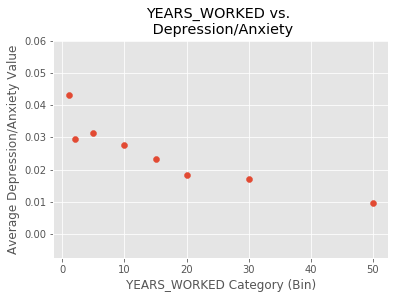

In [16]:
cat_scatter(cdc_combined['YEARS_WORKED'], test_target, cut_last=True)

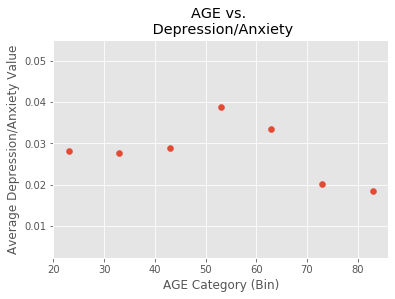

In [17]:
cat_scatter(cdc_combined['AGE'], test_target)

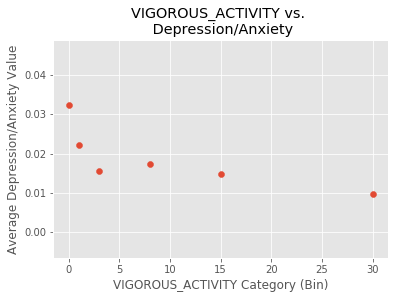

In [18]:
cat_scatter(cdc_combined['VIGOROUS_ACTIVITY'], test_target, cut_last=True)

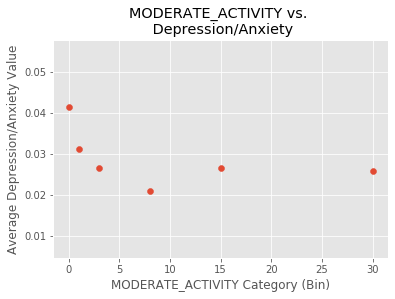

In [19]:
cat_scatter(cdc_combined['MODERATE_ACTIVITY'], test_target, cut_last=True)

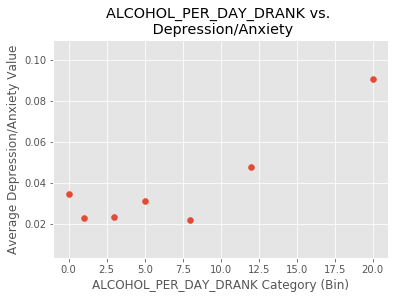

In [20]:
cat_scatter(cdc_combined['ALCOHOL_PER_DAY_DRANK'], test_target, cut_last=True)

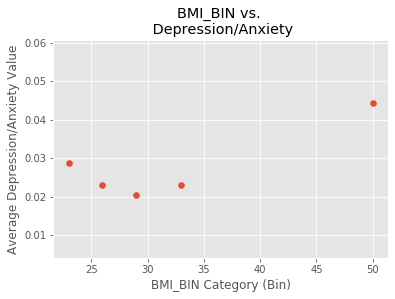

In [21]:
cat_scatter(cdc_combined['BMI_BIN'], test_target)

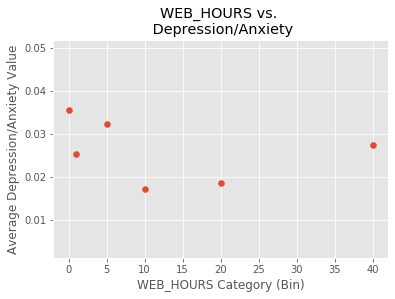

In [22]:
cat_scatter(cdc_combined['WEB_HOURS'], test_target, cut_last=True)

## Establish Best Features

The below cell translates the feature names into sensible descriptions for plotting.

In [123]:
# Creating a dictionary for graphing the most important features in a bar chart.
labels = {'ASINBILL_1': 'Bills: Very Worried', 
          'WRKLYR4_2': 'No Job Past 12 Months',
          'SMKNOW_1': 'Every Day Smoker',
          'ONEJOB_2': 'Did Not Have 2+ Jobs',
          'ASINBILL_4': 'Bills: Not Worried at All',
          'SMKNOW_0': 'Non-Smoker',
          'R_MARITL_1': 'Married: Spouse in Househole',
          'PDSICKA_1': 'Paid Sick Leave',
          'PDSICKA_2': 'No Paid Sick Leave',
          'ASINKNT_4': 'Tight-Knit Neighborhood: Definitely Disagree',
          'MBOMND_2': 'No Mindfulness Meditation',
          'YRSWRKPA_1':'Working for 1 Year',
          'MBO_IMG_1': 'Use Guided Imagery Meditation',
          'YRSWRKPA_50': 'Working for 35+ Years',
          'FSRUNOUT_2': 'Worried Food Will Run Out: Often',
          'FSRUNOUT_1': 'Worried Food Will Run Out: Sometimes',
          'FM_ELDR_0': 'No 65+ Females in Home',
          'ONEJOB_0': 'No Job',
          'VIGOROUS_ACTIVITY_100': 'Vigorous Activity: Never',
          'INCGRP5_4': 'Income: $100,000+',
          'INCGRP5_1': 'Income: Below $35k',
          'INCGRP5_2': 'Income: $35k - $75k',
          'MBO_SPR1_1': 'Use Spiritual Meditatation',
          'MBO_SPR1_2': 'No Spiritual Meditation',
          'FSRUNOUT_3': 'Worried Food Will Run Out: Never',
          'WRKLYR4_0': 'Has Job',
          'FSNAP_1': 'Receives Food Stamps',
          'FSNAP_2': 'No Food Stamps',
          'MBO_MND1_1': 'Uses Mindfulness Meditation',
          'MBO_MND1_2': 'Doesn\t Use Mindfulness Meditation',
          'BMI_BIN_50': 'BMI above 33 (top 20%)',
          'CIGSDAY_0': 'Non-Smoker',
          'MODERATE_ACTIVITY_8': 'Moderate Phys Activity 4-8 times/week',
          'VIGOROUS_ACTIVITY_8': 'Vigorous Phys Activity 4-8 times/week',
          'ALCOHOL_PER_DAY_DRANK_1': '1 Drinks on Days that Drank',
          'ALCOHOL_PER_DAY_DRANK_0': '0 Drinks on Days that Drank',
          'YEARS_WORKED_1': '1 Year at Present Job',
          'R_MARITL_4': 'Marital Status: Widowed',
          'R_MARITL_7': 'Marital Status: Never Married',
          'ASISIM_0': 'Male: Straight, that is, Not Gay',
          'MBO_IMG1_2': 'Doesn\t Use Guided Imagery Meditation',
          'WRKCATA_1': 'Private Company Employee',
          'MRACRPI2_1': 'Race: White',
          'ASISIF_0': 'Female: Straight, that is, Not Gay',
          'ASISIM_2': 'Male: Straight, that is, Not Gay',
          'HOURS_SLEEP_8': '8 Hours Sleep',
          'ALC12MWK_95': 'Did Not Drink Past Year',
          'RAT_CAT5_14': 'Income Ratio to Poverty Threshold: 5.00+',
          'ASINKNT_2': 'Tight-Knit Neighborhood: Somewhat Agree',
          'VIMGLASS_1': 'Wears Glasses or Contact Lenses',
          'MRACRPI2_2': 'Race: Black',
          'VIMGLASS_2': 'Does Not Wear Glasses or Contact Lense',
          'RAT_CAT5_2': 'Income Ratio to Poverty Threshold: .5 - .74',
          'RAT_CAT5_8': 'Income Ratio to Poverty Threshold: 2.0 - 2.49',
          'R_MARITL_5': 'Marital Status: Divorced',
          'AGE_83': 'Age 73 to 83',
          'SUPERVIS_2': 'Does Not Supervise Employees',
          'SUPERVIS_1': 'Does Supervise Employees',
          'MODERATE_ACTIVITY_100': 'Moderate Activity: 30+ Hours/week',
          'BMI_BIN_4': 'BMI 29 - 33',
          'REGION_4': 'Region: West',
          'REGION_3': 'Region: South',
          'HOURS_SLEEP_5': '5 Hours Sleep or Less',
          'HOURS_SLEEP_7': '7 Hours Sleep',
          'ASINBILL_2': 'Bills: Moderatly Worried',
          'FM_KIDS_0': 'No Children Under 18',
          'AWEBEML_1': 'Uses e-mail',
          'AWEBEML_2': 'Does Not Use e-mail',
          'FM_SIZE_1': 'Family Size: 1',
          'FINTR1YN_2': 'No Interest Bearing Accounts, Funds etc.',
          'WEB_HOURS_1': 'Light Internet Use',
          'FM_ELDR_2': '2 Females over 65 in Household',
          'WEB_HOURS_5': 'Medium Internet Use',
          'PAR_STAT_3': 'No Children in Household',
          'ASINKNT_3': 'Close-Knit Neighborhood: Somewhat Disagree',
          'YEARS_WORKED_50': '30+ Years at Present Job',
          'ALC12MWK_0': 'Less than 1 Drink per Week',
          'AWEBMTP_0': 'No Internet Use',
          'FM_STRCP_11': 'Living Alone',
          'REGION_2': 'Midwest',
          'AWEBMTP_1': 'High E-Mail Use'
         }

Performing one-hot encoding for categorical modeling.

In [23]:
# The existing values must first be converted into integers in order to be encoded.
cdc_combined = cdc_combined.astype(int)
you_dummies = pd.get_dummies(cdc_combined, 
                         columns=list(cdc_combined.columns),
                         drop_first=False)

Will first fit a random forest model in order to obtain a ranked list of most important features.

In [63]:
# Create the parameters for the grid search to consider.
grid = {'criterion': ['gini', 'entropy'],
                'max_depth': [7,8,9,10,11],
                'min_samples_split': [2,5,10,15,20,30],
                'min_samples_leaf': [2,5,10,15,20,30],
                'max_features': [20,30,50,100]} 

# Grid search will return a set of optimal parameters for the classifier to use.
best_params_rf = grid_search(RandomForestClassifier, you_dummies, test_target, 
                          grid, verbose=False, n_estimators=100)

# Classifier returns best features to be used for the rest of the modeling,
# helping to alleviate unnecessary dimensions.
best_features_rfc = find_important_features(you_dummies, test_target, 
                                            params=best_params_rf,
                                            classifier=RandomForestClassifier)

Mean Training Score: 79.57%
Mean Test Score: 70.63%
Best Parameter Combination Found During Grid Search:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 30, 'min_samples_leaf': 2, 'min_samples_split': 15}


Creating a correlation matrix in order to establish pos/neg metrics for the most important features.

In [127]:
# Taking only top 100 features as defined by RFC above.
trim_dummies = you_dummies[best_features_rfc.index[:100]]
corr_dummies = pd.concat([you_dummies[best_features_rfc.index[:15]], 
                          test_target], axis = 1)

# Create a correlation matrix for determining pos/neg correlation for important
# features. Sort by original importance.
corr_dummies = corr_dummies.corr()
corr_dummies['to_sort'] = abs(corr_dummies['AFLHCA17'])
to_sort_df = corr_dummies[['AFLHCA17', 'to_sort']][:-1]
corr_dummies

,WRKLYR4_0,ONEJOB_0,ONEJOB_2,FSRUNOUT_3,FSNAP_1,FSNAP_2,MBO_SPR1_1,ASINBILL_4,CIGSDAY_0,MBO_MND1_1,INCGRP5_1,MODERATE_ACTIVITY_8,MBO_SPR1_2,MRACRPI2_1,ASINBILL_1,AFLHCA17,to_sort
WRKLYR4_0,1.000000,-1.000000,0.890320,0.083440,-0.139907,0.140958,-0.000915,-0.059421,0.000145,0.058433,-0.260725,0.039309,0.002430,0.004051,-0.048282,-0.085823,0.085823
ONEJOB_0,-1.000000,1.000000,-0.890320,-0.083440,0.139907,-0.140958,0.000915,0.059421,-0.000145,-0.058433,0.260725,-0.039309,-0.002430,-0.004051,0.048282,0.085823,0.085823
ONEJOB_2,0.890320,-0.890320,1.000000,0.077314,-0.122505,0.123406,-0.013200,-0.044223,-0.007532,0.032435,-0.236158,0.027308,0.012795,0.002100,-0.047123,-0.082414,0.082414
FSRUNOUT_3,0.083440,-0.083440,0.077314,1.000000,-0.320934,0.319773,-0.022320,0.251342,0.160895,-0.002197,-0.277884,0.048829,0.023907,0.109156,-0.342797,-0.125366,0.125366
FSNAP_1,-0.139907,0.139907,-0.122505,-0.320934,1.000000,-0.994073,0.002036,-0.161472,-0.165247,-0.019139,0.353533,-0.065813,-0.006851,-0.140650,0.212101,0.114140,0.114140
FSNAP_2,0.140958,-0.140958,0.123406,0.319773,-0.994073,1.000000,-0.001383,0.162123,0.163559,0.019483,-0.351563,0.067309,0.006886,0.141169,-0.211229,-0.112972,0.112972
MBO_SPR1_1,-0.000915,0.000915,-0.013200,-0.022320,0.002036,-0.001383,1.000000,-0.015597,0.009394,0.328137,0.008154,0.046151,-0.867767,-0.005682,0.025080,0.060662,0.060662
ASINBILL_4,-0.059421,0.059421,-0.044223,0.251342,-0.161472,0.162123,-0.015597,1.000000,0.095375,-0.003460,-0.150496,0.040438,0.084772,0.082322,-0.293668,-0.079044,0.079044
CIGSDAY_0,0.000145,-0.000145,-0.007532,0.160895,-0.165247,0.163559,0.009394,0.095375,1.000000,0.006538,-0.126563,0.030230,-0.006798,-0.006409,-0.124250,-0.079784,0.079784
MBO_MND1_1,0.058433,-0.058433,0.032435,-0.002197,-0.019139,0.019483,0.328137,-0.003460,0.006538,1.000000,-0.025681,0.056295,-0.274777,0.037566,0.004824,0.064109,0.064109


In [128]:
# Creating list of labels from dictionary to apply to graph.
to_sort_df = to_sort_df.iloc[::-1]
# plot_labels = [labels[x] for x,y in to_sort_df.iterrows()]

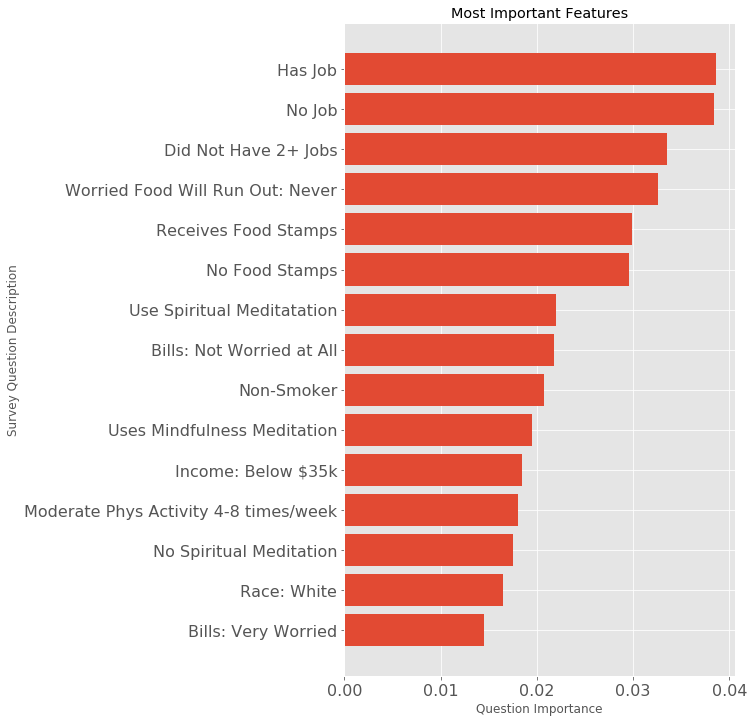

In [137]:
df_importance = best_features_rfc.sort_values(ascending=True).tail(15)
plot_labels = [labels[x] for x,y in to_sort_df.iterrows()]

fig = plt.figure(figsize=(7, 12))
ax = fig.add_subplot(111)
fig.patch.set_facecolor((0,0,0,0))
# ax.patch.set_facecolor((0,0,0,0))
plt.barh(plot_labels, df_importance)
plt.title('Most Important Features')
plt.ylabel('Survey Question Description')
plt.xlabel('Question Importance')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show()

The below graph will demonstrate positive or negative corralation between target and feature.

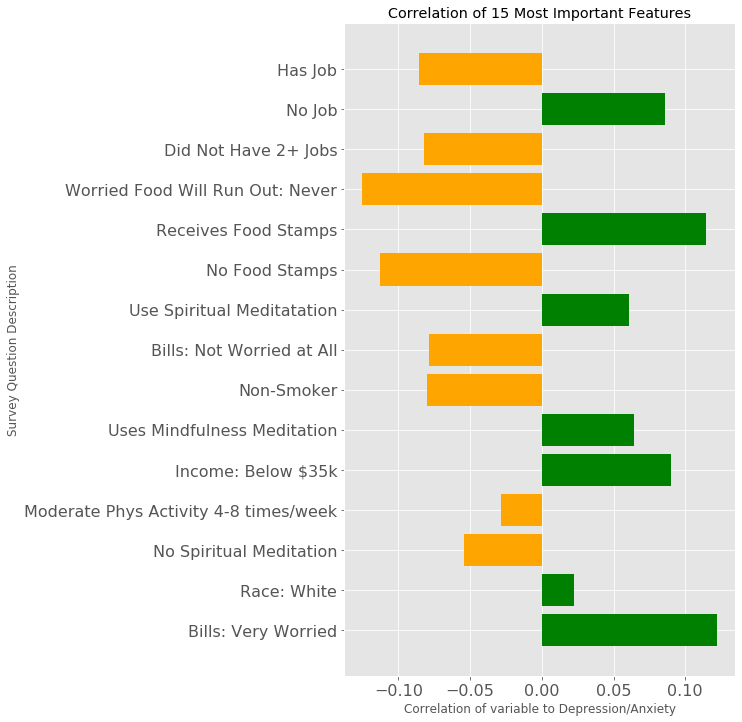

In [136]:
# I'd like to have different colors for pos vs neg.
to_sort_df['positive'] = to_sort_df['AFLHCA17'] > 0
fig = plt.figure(figsize=(7,12))
ax = fig.add_subplot(111)
fig.patch.set_facecolor((0,0,0,0))
# ax.patch.set_facecolor((0,0,0,0))
font = {'color': 'white'}

# plot_labels was established early in the exploration when using most important 
# features to guide modeling.
plt.barh(plot_labels, to_sort_df['AFLHCA17'], 
         color=to_sort_df.positive.map({True: 'green', False: 'orange'}), 
         lw=1);

plt.title('Correlation of 15 Most Important Features')
plt.ylabel('Survey Question Description')
plt.xlabel('Correlation of variable to Depression/Anxiety')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show();




## Individual Testing

Kept for posterity. This was intended to test to see if some of the categorical variables would be better suited non-categorical use. It didn't work out, so I proceeded with one-hotted versions.

In [71]:
tiny_test = combined_sig_data[['YEARS_WORKED', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY',
                          'ALCOHOL_PER_DAY_DRANK', 'BMI_BIN', 'HOURS_SLEEP', 'WEB_HOURS']]

In [72]:
tiny_test.head()

,YEARS_WORKED,VIGOROUS_ACTIVITY,MODERATE_ACTIVITY,ALCOHOL_PER_DAY_DRANK,BMI_BIN,HOURS_SLEEP,WEB_HOURS
0,30,8,100,3,33,8,1
1,1,3,100,3,26,6,1
2,15,0,3,3,50,5,1
3,15,3,8,1,50,8,1
4,20,100,3,3,33,8,10


In [73]:
# The existing values must first be converted into integers in order to be encoded.
tiny_test = tiny_test.astype(int)
tiny_dummies = pd.get_dummies(tiny_test, 
                         columns=list(tiny_test.columns),
                         drop_first=False)

In [74]:
tiny_dummies.head()

,YEARS_WORKED_1,YEARS_WORKED_2,YEARS_WORKED_5,YEARS_WORKED_10,YEARS_WORKED_15,YEARS_WORKED_20,YEARS_WORKED_30,YEARS_WORKED_50,YEARS_WORKED_1000,VIGOROUS_ACTIVITY_0,VIGOROUS_ACTIVITY_1,VIGOROUS_ACTIVITY_3,VIGOROUS_ACTIVITY_8,VIGOROUS_ACTIVITY_15,VIGOROUS_ACTIVITY_30,VIGOROUS_ACTIVITY_100,MODERATE_ACTIVITY_0,MODERATE_ACTIVITY_1,MODERATE_ACTIVITY_3,MODERATE_ACTIVITY_8,MODERATE_ACTIVITY_15,MODERATE_ACTIVITY_30,MODERATE_ACTIVITY_100,ALCOHOL_PER_DAY_DRANK_0,ALCOHOL_PER_DAY_DRANK_1,ALCOHOL_PER_DAY_DRANK_3,ALCOHOL_PER_DAY_DRANK_5,ALCOHOL_PER_DAY_DRANK_8,ALCOHOL_PER_DAY_DRANK_12,ALCOHOL_PER_DAY_DRANK_20,ALCOHOL_PER_DAY_DRANK_100,BMI_BIN_23,BMI_BIN_26,BMI_BIN_29,BMI_BIN_33,BMI_BIN_50,HOURS_SLEEP_5,HOURS_SLEEP_6,HOURS_SLEEP_7,HOURS_SLEEP_8,HOURS_SLEEP_9,HOURS_SLEEP_12,HOURS_SLEEP_15,HOURS_SLEEP_100,WEB_HOURS_0,WEB_HOURS_1,WEB_HOURS_5,WEB_HOURS_10,WEB_HOURS_20,WEB_HOURS_40,WEB_HOURS_1000
0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [75]:
grid = {'criterion': ['gini', 'entropy'],
        'max_depth': [3,6,7,8],
        'max_features': [30,50,200],
        'gamma': [5,10,15,20],
        'max_features': [30,50,300]} 

In [76]:
best_params_xg = grid_search(XGBClassifier, tiny_test[:26311], test_target, grid,
                          verbose=False, n_estimators=50, scoring='accuracy')

Mean Training Score: 52.37%
Mean Test Score: 68.87%
Best Parameter Combination Found During Grid Search:
{'criterion': 'gini', 'gamma': 5, 'max_depth': 3, 'max_features': 30}


Train Accuracy:  0.7009577864490955
Test Accuracy:  0.6886591669200365
Precision:  0.024279210925644917
Recall:  0.2874251497005988
f1_score:  0.04477611940298507

AUC is :0.49


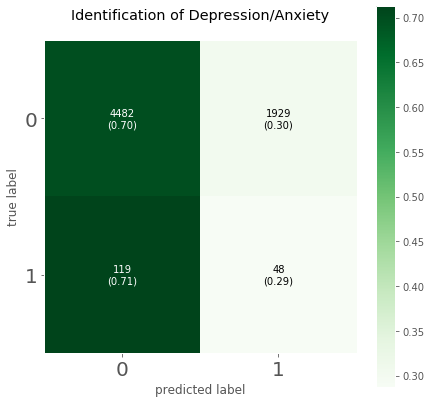

HOURS_SLEEP              0.444926
YEARS_WORKED             0.341876
ALCOHOL_PER_DAY_DRANK    0.213199
WEB_HOURS                0.000000
BMI_BIN                  0.000000
MODERATE_ACTIVITY        0.000000
VIGOROUS_ACTIVITY        0.000000
dtype: float32


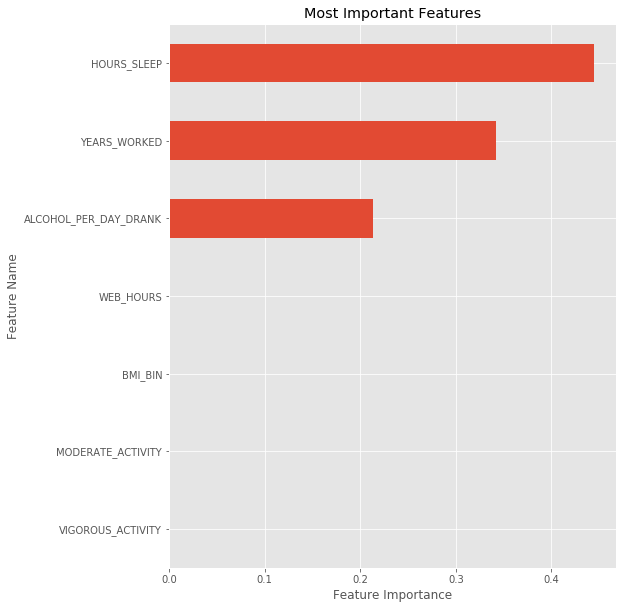

In [79]:
test = tree_builder(tiny_test[:26311], test_target, params=best_params_xg,
             classifier=XGBClassifier)

# Modeling

## Main Target: Depression/Anxiety Duration

### Decision Tree Classifier

In [80]:
grid = {'criterion': ['gini', 'entropy'],
        'max_depth': [2,3,6,7,8],
        'min_samples_split': [2,5,10,15,20,30],
        'min_samples_leaf': [2,5,10,15,20,30],
        'max_features': [20,30,50,100]} 

In [81]:
best_params_dtc = grid_search(DecisionTreeClassifier, trim_dummies, test_target, 
                          grid, verbose=False)

Mean Training Score: 72.81%
Mean Test Score: 74.55%
Best Parameter Combination Found During Grid Search:
{'criterion': 'gini', 'max_depth': 6, 'max_features': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}


Train Accuracy:  0.7399787158566867
Test Accuracy:  0.7341137123745819
Precision:  0.051587301587301584
Recall:  0.5449101796407185
f1_score:  0.09425168306576902

AUC is :0.64


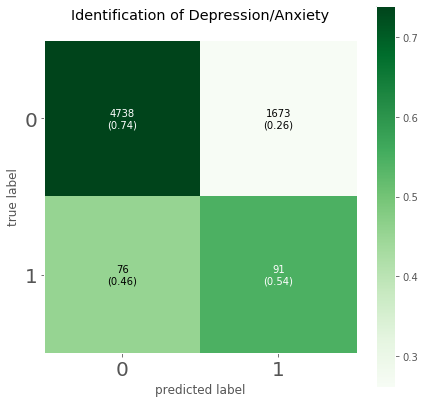

INCGRP5_1              0.237729
WRKLYR4_0              0.129005
MBO_SPR1_1             0.095555
ASINBILL_4             0.051832
VIMGLASS_1             0.044599
MODERATE_ACTIVITY_8    0.038856
FSNAP_1                0.038434
MRACRPI2_2             0.032087
YEARS_WORKED_1         0.032026
YEARS_WORKED_15        0.026041
dtype: float64


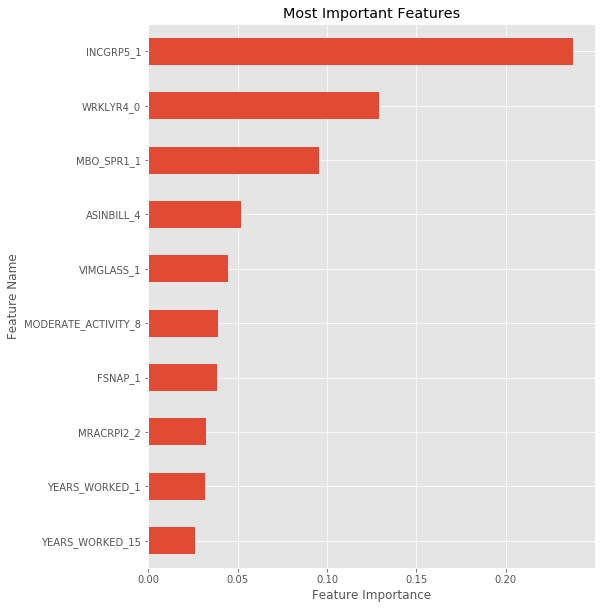

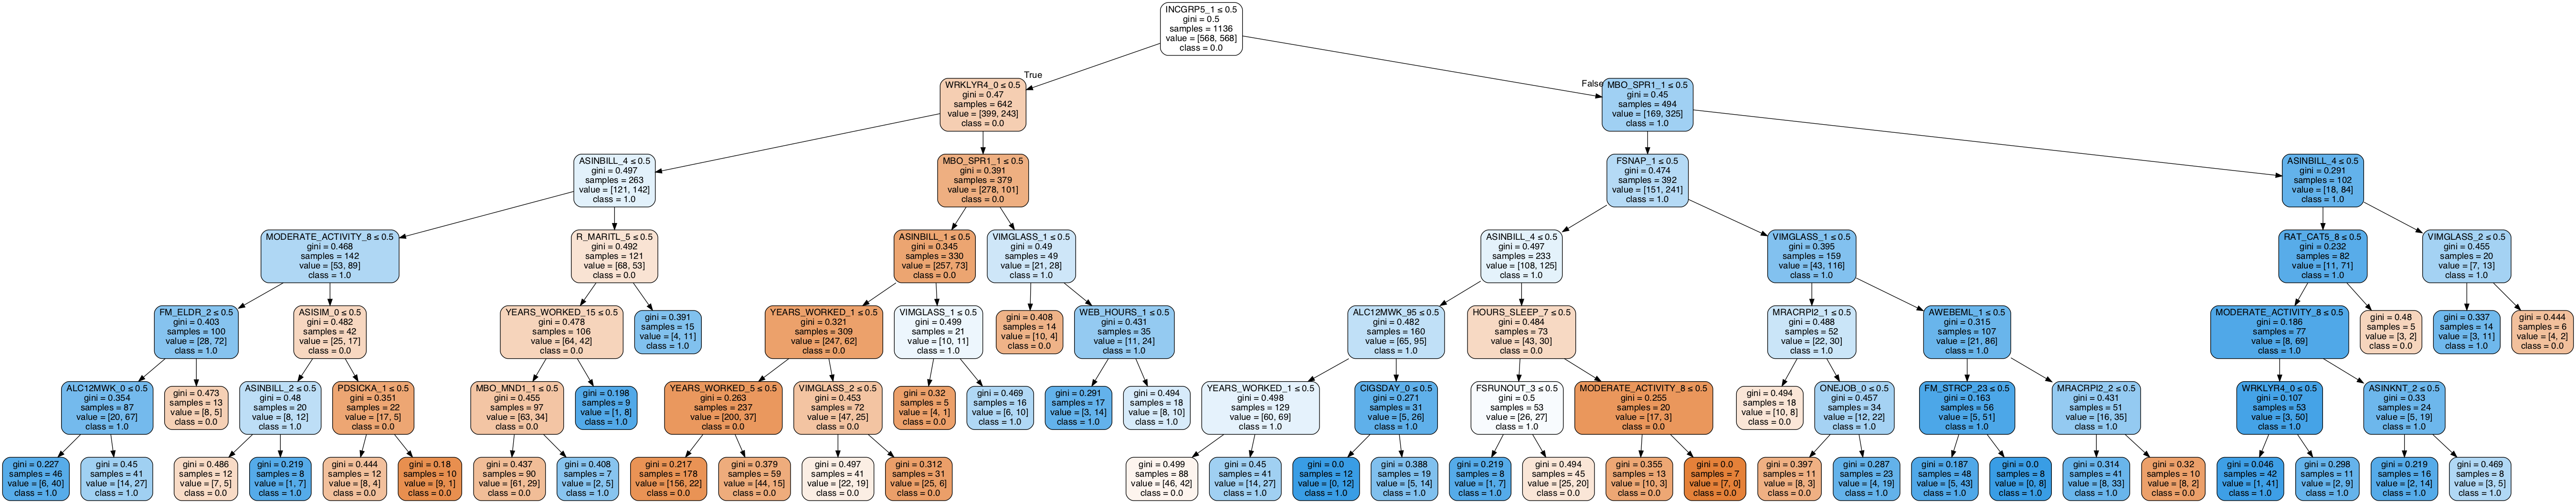

In [82]:
tree_builder(trim_dummies, test_target, params=best_params_dtc)

### Random Forest Model with Grid Search

In [83]:
grid = {'criterion': ['gini', 'entropy'],
        'max_depth': [2,3,6,7,8],
        'min_samples_split': [2,5,10,15,20,30],
        'min_samples_leaf': [2,5,10,15,20,30],
        'max_features': [20,30,50,100]} 

In [84]:
best_params_rf = grid_search(RandomForestClassifier, trim_dummies, test_target, 
                          grid, verbose=False, n_estimators=100)

Mean Training Score: 76.78%
Mean Test Score: 70.33%
Best Parameter Combination Found During Grid Search:
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}


Train Accuracy:  0.705011908984949
Test Accuracy:  0.7014290057768319
Precision:  0.05934281510544385
Recall:  0.7245508982035929
f1_score:  0.10970081595648233

AUC is :0.71


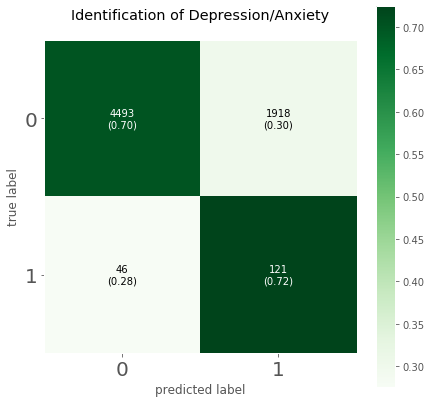

WRKLYR4_0     0.038643
ONEJOB_0      0.038425
ONEJOB_2      0.033497
FSRUNOUT_3    0.032599
FSNAP_1       0.029871
FSNAP_2       0.029580
MBO_SPR1_1    0.021947
ASINBILL_4    0.021763
CIGSDAY_0     0.020793
MBO_MND1_1    0.019488
dtype: float64


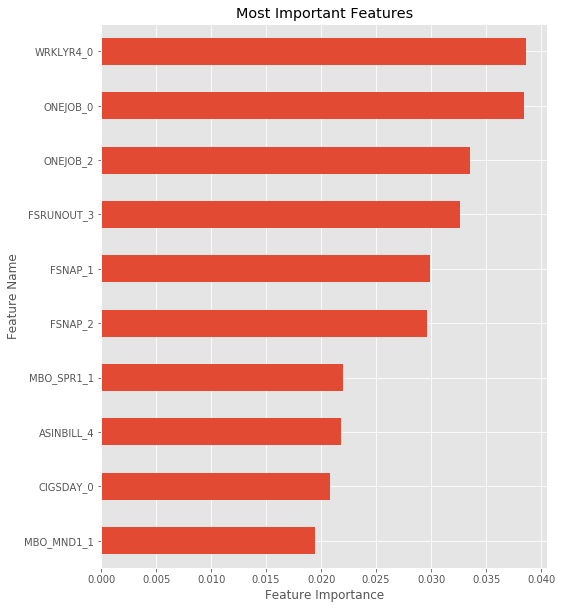

In [85]:
best_features_rfc = tree_builder(trim_dummies, test_target, 
                                 params=best_params_rf,
                                 classifier=RandomForestClassifier)

### XGBoost Model with Grid Search

In [86]:
# Create a spectrum of values to test against.
grid = {'criterion': ['gini', 'entropy'],
        'max_depth': [3,6,7,8],
        'max_features': [30,50,200],
        'gamma': [5,10,15,20],
        'max_features': [30,50,300]} 

# grid_search function returns the params to be used in the model.
best_params_xg = grid_search(XGBClassifier, trim_dummies, test_target, grid,
                          verbose=False, n_estimators=50, scoring='accuracy')

Mean Training Score: 76.27%
Mean Test Score: 71.68%
Best Parameter Combination Found During Grid Search:
{'criterion': 'gini', 'gamma': 5, 'max_depth': 3, 'max_features': 30}


Train Accuracy:  0.7172756296559063
Test Accuracy:  0.7166311948920645
Precision:  0.06013478486262312
Recall:  0.6946107784431138
f1_score:  0.11068702290076336

AUC is :0.71


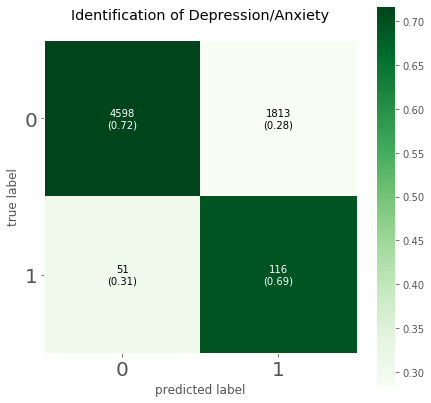

FSRUNOUT_3    0.067764
ONEJOB_0      0.067572
INCGRP5_1     0.065155
FSNAP_2       0.036770
FM_ELDR_0     0.031508
ASINBILL_4    0.027961
FM_ELDR_2     0.026497
CIGSDAY_0     0.026302
MBO_MND1_1    0.024847
ONEJOB_2      0.023802
dtype: float32


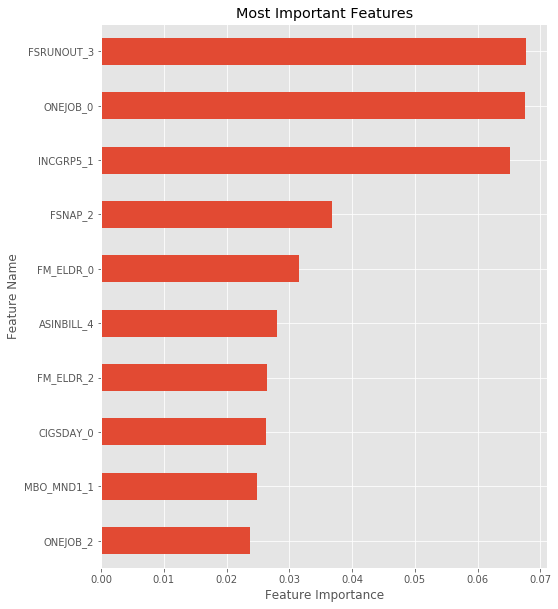

In [87]:
# This is the function that creates the modeling and plotting.
best_features = tree_builder(trim_dummies, test_target, params=best_params_xg,
             classifier=XGBClassifier)

### Support Vector Classifier

**Best Model**

This was the one that performed the best. With true negative and true values both almost 3/4, it showed a healthy degree of utility. With a target size of 750 compared to a total sample size of 26,000, it was a bit like finding a needle in a haystack, but the results have worked out modestly well.

In [88]:
grid = {'kernel': ['linear','poly','sigmoid', 'rbf'],
        'C': [4,5,6,7,8],
        'gamma': ['auto', 'scale']} 

Grid search for parameters. Commenting out so it won't take up computing time when re-running notebook.

In [89]:
best_params_svc = grid_search(SVC, trim_dummies, test_target,
                          grid, verbose=False, scoring='accuracy')

Mean Training Score: 82.58%
Mean Test Score: 72.80%
Best Parameter Combination Found During Grid Search:
{'C': 5, 'gamma': 'auto', 'kernel': 'sigmoid'}


In [90]:
# Backup params in case I don't want to re-run grid search.
# svc_params = {'C': 6, 'gamma': 'auto', 'kernel': 'sigmoid'}

Train Accuracy:  0.7300967921755435
Test Accuracy:  0.728032836728489
Precision:  0.06538049303322616
Recall:  0.7305389221556886
f1_score:  0.12001967535661585

AUC is :0.79


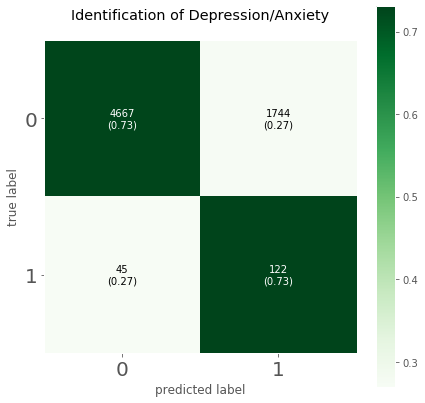

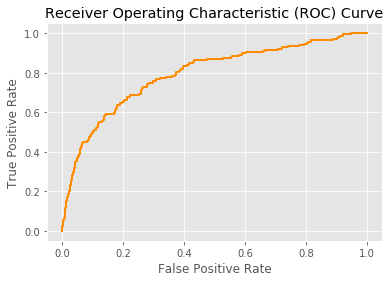

In [91]:
tree_builder(trim_dummies, test_target, params=best_params_svc,
             classifier=SVC)

### K Nearest Neighbors

In [94]:
knn_params = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}

In [95]:
best_params_knn = grid_search(KNeighborsClassifier, trim_dummies, test_target,
                          knn_params, verbose=False, scoring='recall')

Mean Training Score: 67.65%
Mean Test Score: 65.87%
Best Parameter Combination Found During Grid Search:
{'n_neighbors': 19}


Train Accuracy:  0.7536107028834946
Test Accuracy:  0.7555487990270598
Precision:  0.06622516556291391
Recall:  0.6586826347305389
f1_score:  0.12035010940919039

AUC is :0.71


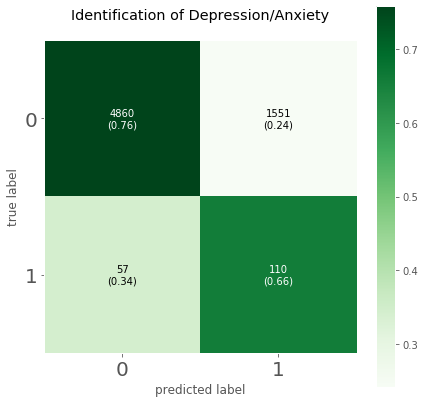

In [96]:
tree_builder(trim_dummies, test_target, params=best_params_knn,
             classifier=KNeighborsClassifier)

## Side Targets

I did a few additional targets on other subjects to find out if there was anything worthwhile.

There wasn't really much here, but I'm keeping it in as a means of demonstrating repeatability. The functions I've created make displaying a fairly complete analysis of each target very simple to do. 

### Bipolar, Schizophrenia etc.

The sample size for the target values was far too small to be useful.

In [98]:
target_bi = cdc_ad['AFLHCA17']
target_bi = target_bi.fillna(0)
target_bi = target_bi.where(target_bi == 1, 0)

In [99]:
target_bi = target_bi.fillna(0)
target_bi = target_bi.where(target_bi == 1, 0)

In [100]:
target_bi = target_bi[:26311]

Grid search for parameters. Commenting out so it won't take up computing time when re-running notebook.

In [101]:
grid = {'kernel': ['linear','poly','sigmoid', 'rbf'],
        'C': [.001,5,6,7,8],
        'gamma': ['auto', 'scale']} 

best_params_svc = grid_search(SVC, trim_dummies, target_bi,
                          grid, verbose=False, scoring='f1')

Mean Training Score: 65.62%
Mean Test Score: 6.35%
Best Parameter Combination Found During Grid Search:
{'C': 5, 'gamma': 'auto', 'kernel': 'poly'}


In [102]:
bi_params = {'kernel': 'poly',
            'C': .001,
            'gamma': 'scale'} 

Train Accuracy:  0.3910707951147823
Test Accuracy:  0.3861356035269079
Precision:  0.03332522500608125
Recall:  0.681592039800995
f1_score:  0.06354359925788497

AUC is :0.52


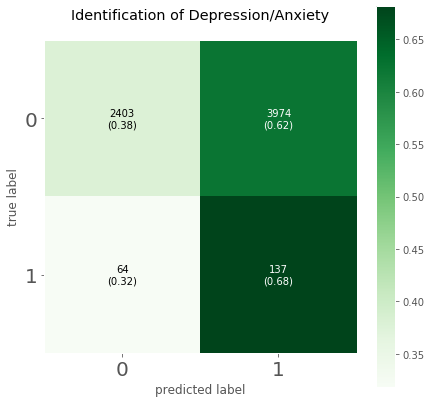

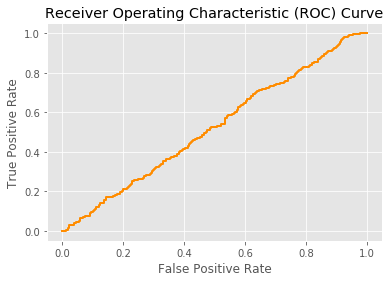

In [103]:
tree_builder(trim_dummies, target_bi, params=best_params_svc,
             classifier=SVC)

### Kidney Problems

Another small sample size, such that no conclusions could be found.

In [104]:
target_kid = cdc_ad['KIDWKYR']

target_kid = target_kid.fillna(0)
target_kid = target_kid.where(target_kid == 1, 0)

target_kid = target_kid[:26311]

Grid search for parameters. Commenting out so it won't take up computing time when re-running notebook.

In [105]:
grid = {'kernel': ['linear','poly','sigmoid', 'rbf'],
        'C': [4,5,6,7,8],
        'gamma': ['auto', 'scale']} 

best_params_svc = grid_search(SVC, trim_dummies, target_kid,
                          grid, verbose=False, scoring='accuracy')

Mean Training Score: 72.15%
Mean Test Score: 56.64%
Best Parameter Combination Found During Grid Search:
{'C': 6, 'gamma': 'auto', 'kernel': 'poly'}


Train Accuracy:  0.5811584655146201
Test Accuracy:  0.5664335664335665
Precision:  0.021754636233951498
Recall:  0.3588235294117647
f1_score:  0.04102219233355749

AUC is :0.47


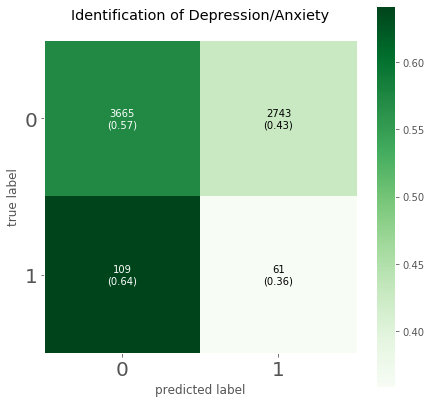

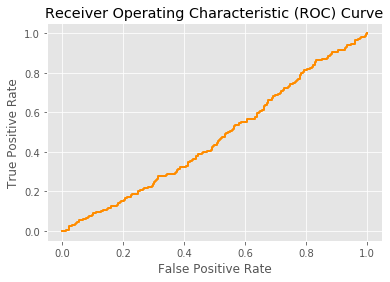

In [106]:
tree_builder(trim_dummies, target_kid, params=best_params_svc,
             classifier=SVC)

### Heavy Drinking

Not sure why this one didn't work out, aside from the fact that the data set was culled with mental illness in mind rather than drinking, but many of the features should have been the same. Something I would have explored with more time, but it wasn't the primary interest.

In [107]:
# There had to be some re-arranging for this one since there were several 
# related columns in the original data set.
alc_combined = cdc_combined.drop(['ALC12MWK', 'ALCOHOL_PER_DAY_DRANK'], 
                                axis = 1)

alc_combined = alc_combined.astype(int)
drunk_dummies = pd.get_dummies(alc_combined, 
                         columns=list(alc_combined.columns),
                         drop_first=False)

trim_dummies = drunk_dummies[drunk_dummies.columns[:40]]

# average drinks per day, days per year, days per week.
cdc_alc = cdc_ad[['ALCAMT', 'ALC12MYR', 'ALC12MWK']].copy()

Find out how many heavy drinkers there are. Will need to do some feature engineering to split this up by sex.

In [108]:
cdc_alc[(cdc_alc['ALCAMT'] * cdc_alc['ALC12MYR']) >= 430].count() # 780 for men

ALCAMT      2354
ALC12MYR    2354
ALC12MWK    2354
dtype: int64

In [109]:
cdc_alc['DRINKS_PER_YEAR'] = cdc_alc['ALCAMT'] * cdc_alc['ALC12MYR']

cdc_alc['DRINKS_PER_YEAR'].fillna(0, inplace=True)

target_alc = cdc_alc.DRINKS_PER_YEAR.map(lambda x: 1 if x > 430 else 0)
# [for cdc_alc.map('ALCAMT' * 'ALC12MYR' >= 780, 0)

target_alc = target_alc[:26311]

Grid search for parameters. Commenting out so it won't take up computing time when re-running notebook.

In [110]:
grid = {'kernel': ['linear','poly','sigmoid', 'rbf'],
        'C': [4,5,6,7,8],
        'gamma': ['auto', 'scale']} 

best_params_svc = grid_search(SVC, trim_dummies, target_alc,
                          grid, verbose=False, scoring='recall')

Mean Training Score: 55.05%
Mean Test Score: 56.86%
Best Parameter Combination Found During Grid Search:
{'C': 4, 'gamma': 'auto', 'kernel': 'poly'}


In [111]:
svc_params = {'C': 6, 'gamma': 'auto', 'kernel': 'sigmoid'}

Train Accuracy:  0.4245679825672731
Test Accuracy:  0.42566129522651264
Precision:  0.0890960890960891
Recall:  0.5685950413223141
f1_score:  0.1540528437080161

AUC is :0.5


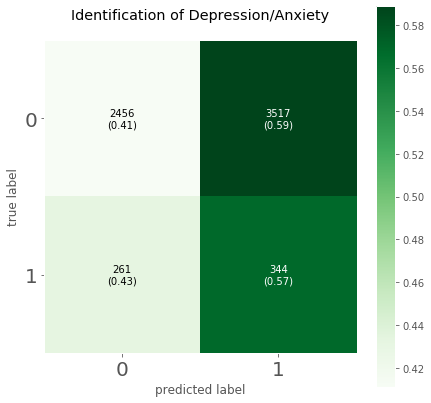

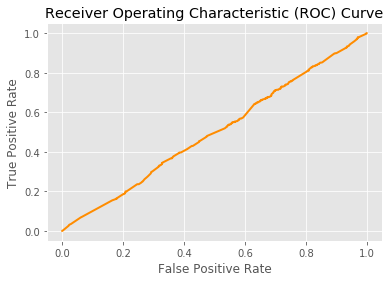

In [112]:
tree_builder(trim_dummies, target_alc, params=best_params_svc,
             classifier=SVC)

# Conclusions

## Summary

There were five models generated for the target data of individuals classified as having dibilitating depression or anxiety. The decision tree was the first, as it was an easy model from which to pull robust metrics and visuals. The results were fine but not fantastic. The next model was the random forest, which definitely improved the output figures. A natural progression led to the XGBoost model, which made further improvments still. It was followed up with the Support Vector Classifier, which was the model I identified for the best model for my purposes. After that came the K Nearest Neighbors model, which actually had a higher accuracy, but the the AUC was higher on the SVC, and recall was superior, which I felt was important in maximizing positive hits as opposed with avoiding false positives. Better to capture as many at-risk individuals as possible.

As for the final output, I had an accuracy value of .74 with the Support Vector Classifier. This model was able to create a definite prediction regarding debilitating depression and anxiety. True positive and true negative values relative to their false counterparts were both nearly 75%. The f1 score was also superior to the other models at 12.6, which sounds terrible but it was a very small target in comparison with the overall sample. While there were a sizeable number of false positives, the model caught the majority of mentally ill individuals.

With some strong tools and enough data, mental illness, and depression and anxiety in particular, can be predicted to a fairly strong extent based on economic factors and personal lifestyles. While it can't necessarily be ascertained which causes which -- whether, for example, individuals have difficulty maintaining employment because they have debilitating depression and/or anxity or if they have debilitating depression and/or anxity because they are unemployed -- that distinction does not necessarily matter. While more research would need to be done to investigate and dissect unique factors (such as unemployment or poverty), a report such as this can be used as a tool to assist in determining which features to pursue, as well as carving out segments of the popoulation that are more likely to be at risk and allocating budgets for mental health intervention appropriately.

Further, because so many of the most important factors were economic in nature, it may be indicative of the need to address poverty issues one way or another. Whether poverty causes debilitating depression and anxiety or depression and anxiety cause poverty is beside the point; the reality is that these forms of mental illness exist under those circumstances, for one reason or another, and should be addressed accordingly.

Though I am includeing below the top 50 most important features used in identifying debilitating depression and anxiety in this report, the individual variables should not be used on their own to make judgments about any particular aspect, especially if the correlation is close to center. This report is the culmination of 100 separate variables, and there is planty of margin for error in the details. For example, black race shows just left of center as being at less risk for debilitating depression and anxiety, while white race shows just to the right as being slightly more at risk for debilitating depression and anxiety. This is not an argument that racial injustice has been alleviated and people with African heritage have finally reached parity with those of Eurpoean heritage. The only question this report is equipped to answer is who is more at risk for debilitating depression and anxiety; any other arguments about relative happiness or well being are far beyong the scope of the data herein.

## Recommendations

There are two important things to consider given these conclusions. One is that we can identify those individuals who are most at risk for debilitating depression and anxiety, especially those in low economic status. This can guide decision-makers in allocating mental health resources to those areas most in need. The other side is that, knowing that poverty plays some part in these diseases, find the means to alleviate that poverty in our society.

## Important Feature Plot

In [124]:
# Put the target together with the original dummy set to establish correlation
# for plotting.
corr_dummies = pd.concat([you_dummies[best_features_rfc.index[:50]], 
                          test_target], axis = 1)
corr_dummies = corr_dummies.corr()
corr_dummies['to_sort'] = abs(corr_dummies['AFLHCA17'])
# Take everything but the target.
to_sort_df = corr_dummies[['AFLHCA17', 'to_sort']][:-1]
# Reverse the order for sorting
to_sort_df = to_sort_df.iloc[::-1]
plot_labels = [labels[x] for x,y in to_sort_df.iterrows()]

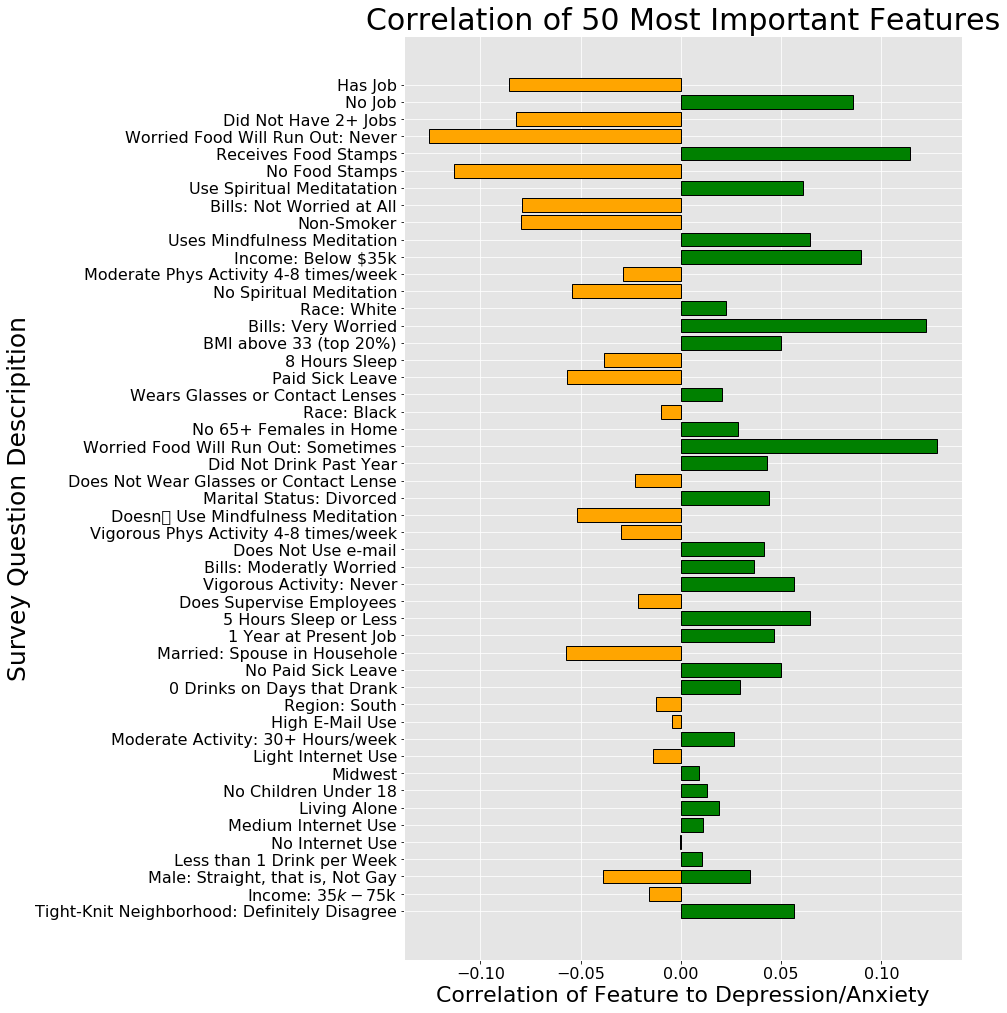

In [125]:
# I'd like to have different colors for pos vs neg.
to_sort_df['positive'] = to_sort_df['AFLHCA17'] > 0
fig = plt.figure(figsize=(10, 17))
ax = fig.add_subplot(111)
fig.patch.set_facecolor((0,0,0,0))

# plot_labels was established early in the exploration when using most 
# important features to guide modeling.
plt.barh(plot_labels, to_sort_df['AFLHCA17'], 
         color=to_sort_df.positive.map({True: 'green', False: 'orange'}), 
                                        edgecolor='black', lw=1)
plt.title('Correlation of 50 Most Important Features', color='black', fontsize=30)
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='black', labelsize=16)
ax.tick_params(axis='y', colors='black', labelsize=16)
plt.xlabel('Correlation of Feature to Depression/Anxiety', color='black', 
           fontsize=22)
plt.ylabel('Survey Question Descripition', color='black', fontsize=25)
plt.show()